In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import pandas as pd
from torch.nn.utils.rnn import pad_packed_sequence
import logging
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence

from batteryprobe.data import create_data_loader
from batteryprobe.loops import evaluate
from batteryprobe.utils import pad_and_pack, masked_l1

In [27]:
logging.getLogger('matplotlib').setLevel(logging.ERROR)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [66]:
plt.rcParams["figure.figsize"] = (18,6)

In [67]:
df = pd.read_csv("data_54.38.188.95/all.csv")
df = df.iloc[::5]
df

,Unnamed: 0,time,battery_status,manufacturer,os,uuid,charge_full,mean_fans_rpm,current_now,voltage_min_design,...,battery_temp,cpu_temp,swap_load,fans_rpm,ram_load,number_of_fans,capacity,charge_full_design,charge_now,load_average_15
0,0,1.601834e+09,Charging,SWD,macos,13370f11455f4f36a0680b9725189375,4089.0,0.0,2053.0,NaN,...,40.00,55.63,NaN,0.0,NaN,2.0,NaN,5088.0,3289.0,2.63
5,5,1.601834e+09,Charging,SWD,macos,13370f11455f4f36a0680b9725189375,4089.0,0.0,1863.0,NaN,...,40.09,58.56,NaN,0.0,NaN,2.0,NaN,5088.0,3354.0,2.69
10,10,1.601834e+09,Full,BYD,linux,5fbc9f85604740eb85dbf9dbd495de67,2760.0,NaN,1.0,11400.0,...,NaN,56.00,36572.0,0.0,7603168.0,NaN,100.0,3684.0,2760.0,2.12
15,15,1.601834e+09,Charging,SWD,macos,13370f11455f4f36a0680b9725189375,4089.0,0.0,1756.0,NaN,...,40.00,55.50,NaN,0.0,NaN,2.0,NaN,5088.0,3383.0,2.76
20,20,1.601834e+09,Charging,SWD,macos,13370f11455f4f36a0680b9725189375,4089.0,0.0,1682.0,NaN,...,38.80,59.00,NaN,0.0,NaN,2.0,NaN,5088.0,3411.0,2.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430110,430110,1.607609e+09,Discharging,Simplo,linux,e18acda9486c41fc8d19777cd114ac39,2300.0,NaN,1354.0,14400.0,...,NaN,48.00,0.0,2500.0,224848.0,NaN,64.0,3350.0,1476.0,0.50
430115,430115,1.607608e+09,Full,SWD,macos,13370f11455f4f36a0680b9725189375,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,2.0,NaN,NaN,NaN,2.99
430120,430120,1.607608e+09,Charging,Simplo,linux,e18acda9486c41fc8d19777cd114ac39,NaN,NaN,488.0,14400.0,...,NaN,49.00,2328.0,3200.0,3472772.0,NaN,NaN,NaN,NaN,2.66
430125,430125,1.607608e+09,Charging,Simplo,linux,e18acda9486c41fc8d19777cd114ac39,NaN,NaN,NaN,14400.0,...,NaN,NaN,2328.0,NaN,3487440.0,NaN,NaN,NaN,NaN,NaN


In [64]:
params = {
    "max_gap_between_sessions": 400,
    "min_num_points_per_session": 10,
    "min_session_duration": 600,
    "label_lower_bound": 0.2,
    "label_upper_bound": 0.5,
    "train_split": 0.7,
    "features": [
        #'charge_full',
        'current_now',
        'n_running_threads',
        'load_average_5',
        'load_average_1',
        'load_average_15',
        #'voltage_now',
        'cpu_temp',
        #'fans_rpm',
        'charge_full_design',
        'charge_now',
    ],
    "context": [
        #'time',
        'epoch_sin_day',
        'battery_status_Charging',
        'battery_status_Discharging',
        'os_linux',
        'os_macos'
    ],
    "batch_size": 12,
    "repeat": 10,
}

In [30]:
train, val = create_data_loader(df, params)

INFO:root:26077 data points
DEBUG:root:13370f11455f4f36a0680b9725189375 - 3865 points
DEBUG:root:Extracted 80 sessions
DEBUG:root:5fbc9f85604740eb85dbf9dbd495de67 - 1105 points
DEBUG:root:Extracted 29 sessions
DEBUG:root:0a236299cff2433fbd19467990418ba4 - 8855 points
DEBUG:root:Extracted 126 sessions
DEBUG:root:e7bbfc496d57492a82e68d8cf2835761 - 4 points
DEBUG:root:Extracted 0 sessions
DEBUG:root:6c328af026994ab5ae14d1eb27d92e2b - 8675 points
DEBUG:root:Extracted 143 sessions
DEBUG:root:e18acda9486c41fc8d19777cd114ac39 - 3573 points
DEBUG:root:Extracted 71 sessions
INFO:root:Extracted 449 sessions


In [32]:
for (inputs, context), label in train:
    unpacked_inputs, lengths = pad_packed_sequence(inputs, batch_first=True, padding_value=-999)
    print(unpacked_inputs.shape)
    print(lengths)
    unpacked_context, lengths = pad_packed_sequence(context, batch_first=True, padding_value=-999)
    print(unpacked_context.shape)
    print(lengths)
    break

torch.Size([12, 60, 13])
tensor([11, 39, 15,  4, 31,  5,  5, 23,  4, 60, 45,  6])
torch.Size([12, 88, 5])
tensor([14, 45, 16, 16, 32, 10,  8, 44, 15, 88, 57,  7])


In [33]:
target_col = params["features"].index("charge_now")
target_col

7

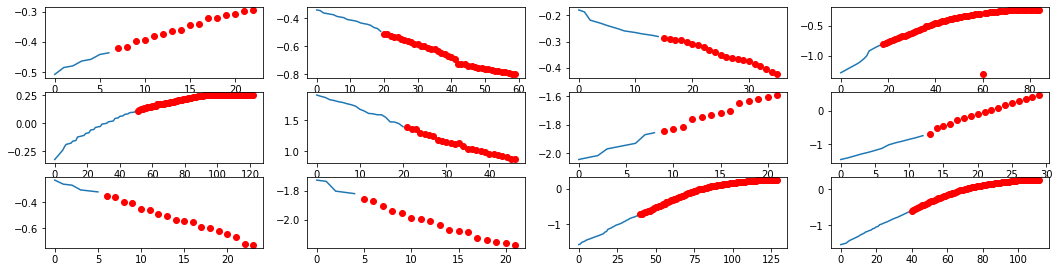

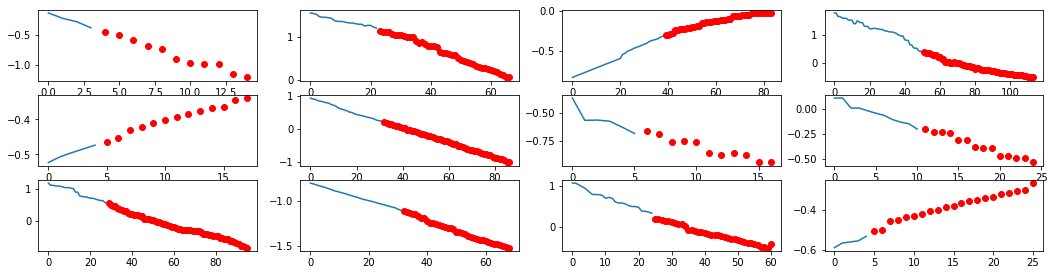

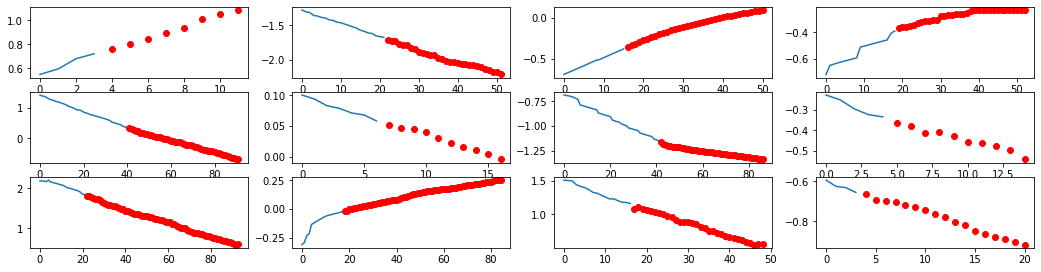

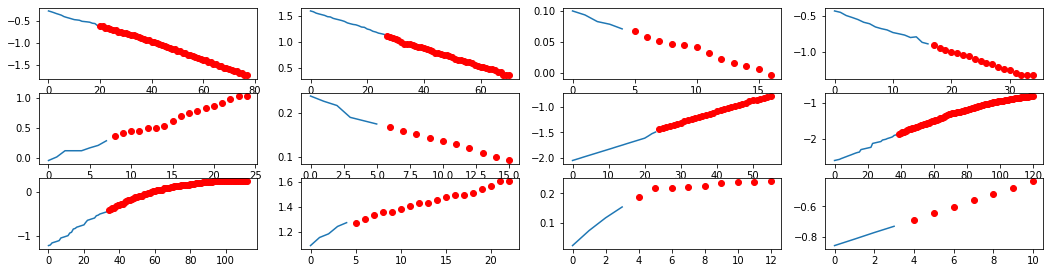

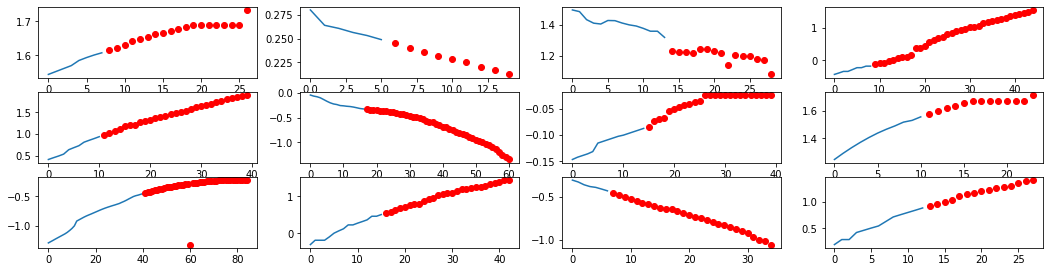

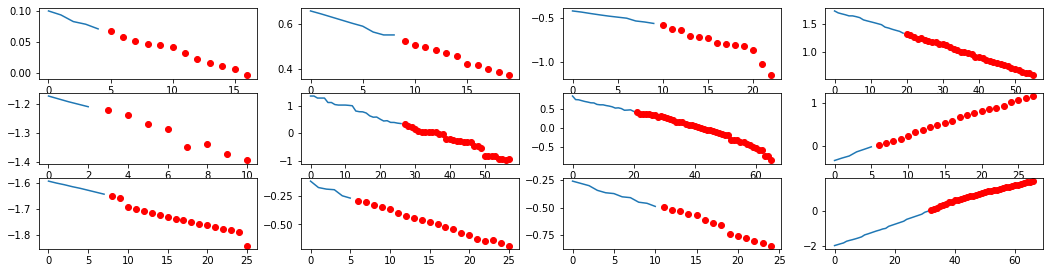

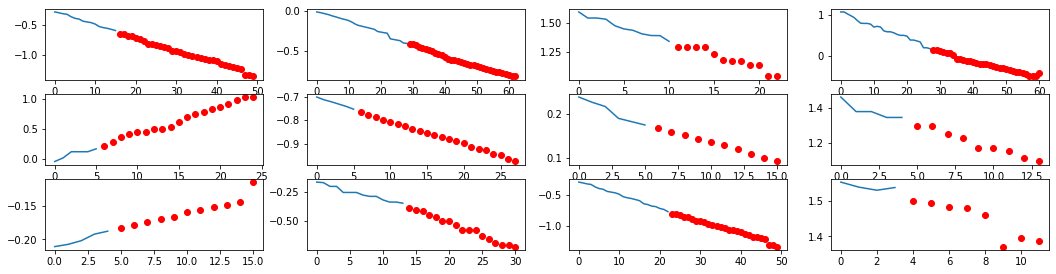

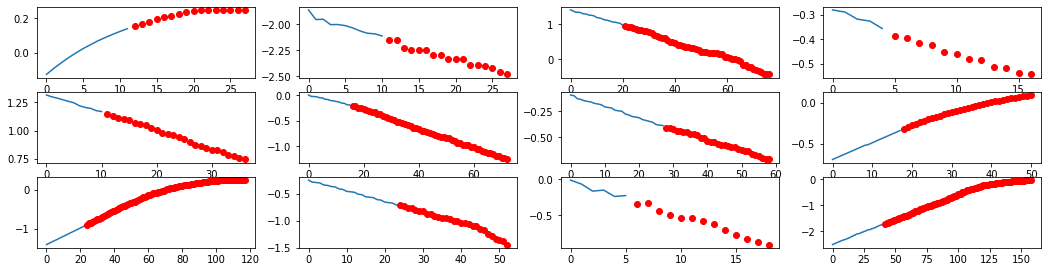

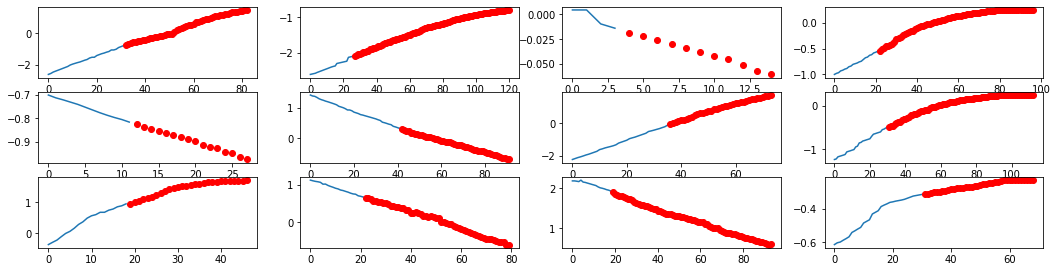

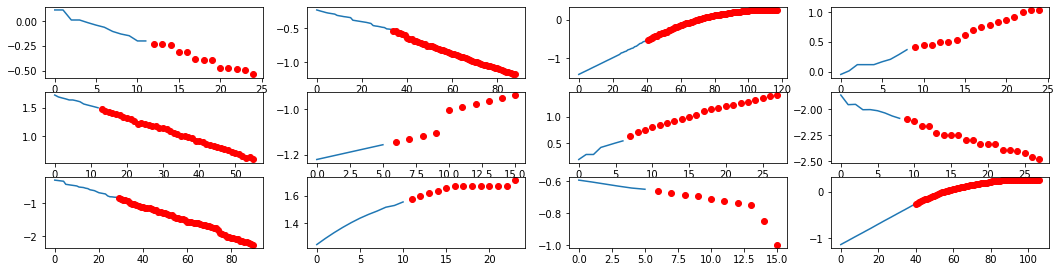

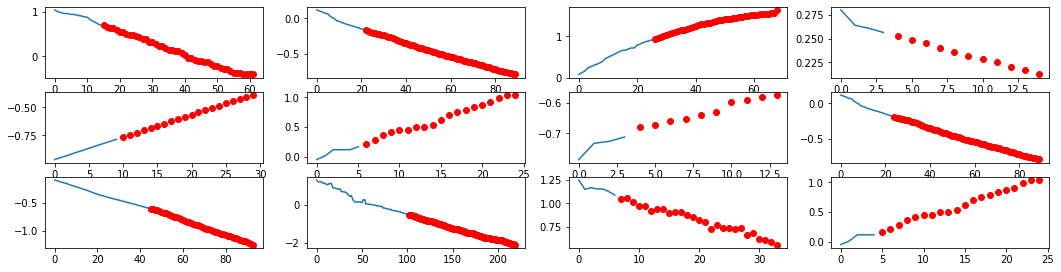

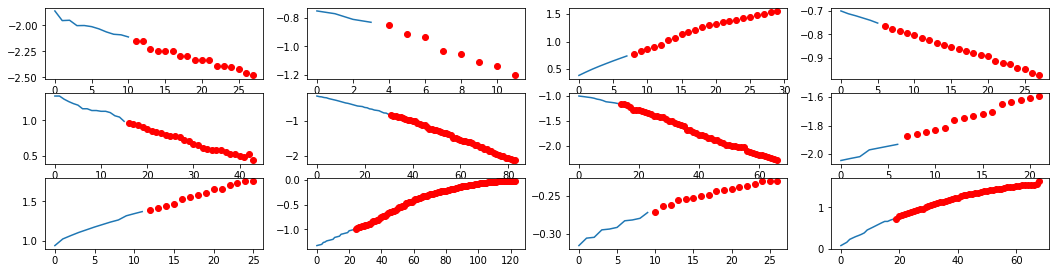

KeyboardInterrupt: 

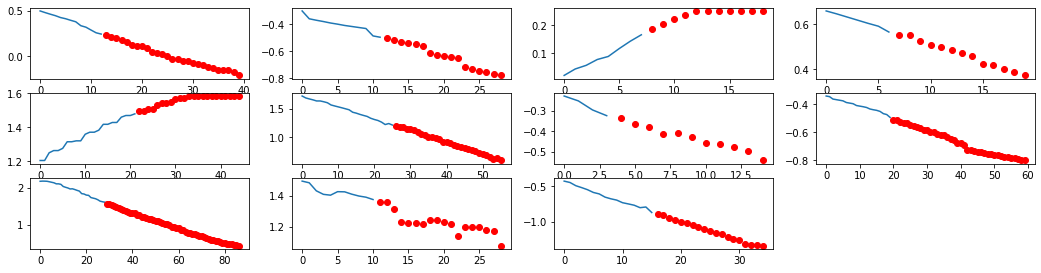

In [69]:
for (inputs, context), labels in train:
    inputs, inputs_len = pad_packed_sequence(inputs, batch_first=True, padding_value=-999)
    labels, labels_len = pad_packed_sequence(labels, batch_first=True, padding_value=-999)
    for index, input_len in enumerate(inputs_len):
    #print(inputs.shape) 
    #print(labels.shape)
        plt.subplot(4,4,index+1)
        plt.plot(
            np.arange(0, inputs_len[index]), 
            inputs[index, :inputs_len[index], target_col]
        )
        plt.plot(
            np.arange(inputs_len[index], labels_len[index]+inputs_len[index]), 
            labels[index, :labels_len[index], target_col], "ro"
        )
    plt.show()

In [70]:
class AutoRegressive(nn.Module):
    def __init__(self, params):
        self.params = params
        super(AutoRegressive, self).__init__()
        self.in_size = len(self.params["features"]) + len(self.params["context"])
        self.out_size = len(self.params["features"])
        self.lstm = nn.LSTM(self.in_size, 32, batch_first=True)
        self.dense = nn.Linear(32, self.out_size)
    
    def forward(self, x, context):
        predictions = []
        x, warmup_state = self.warmup(x)
        predictions.append(x)
        print(type(context))
        
        context, lengths_context = pad_packed_sequence(context, batch_first=True, padding_value=-999)
        # Loop over every element of a batch
        batch = []
        for i, element in enumerate(x):
            # State corresponding to a single element in a batch
            state = (
                warmup_state[0][:, i, :][None, :],
                warmup_state[1][:, i, :][None, :],
            )
            
            # Add first prediction from warmup
            timestamps = [element[None, None, :]]
            
            # Predict values
            for t in range(lengths_context[i]-1):
                # The order here is important. Inputs features should be first
                in_tensor = torch.cat([element, context[i, t, :]], axis=-1)[None, None, :] 
                x, state = self.lstm(in_tensor, state)
                x = self.dense(x)
                timestamps.append(x)
            batch.append(torch.cat(timestamps, 1)[0])

        # Pack and pad sequence
        return pad_and_pack(batch)

    def warmup(self, x):
        x, state = self.lstm(x)
        x, lengths = pad_packed_sequence(x, batch_first=True, padding_value=-999)
        x = torch.stack([x[i, length-1] for i, length in enumerate(lengths)])
        x = self.dense(x)
        return x, state 

In [71]:
from batteryprobe.models import AutoRegressive

In [84]:
model = AutoRegressive(params)

In [85]:
N_EPOCHS = 20
LEARNING_RATE = 1e-2

criterion = masked_l1
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

history = []
val_history = []

for epoch in range(N_EPOCHS):
    
    # Training 
    running_loss = 0
    pbar = tqdm(train) 
    for i, ((inputs, context), labels) in enumerate(pbar):
        optimizer.zero_grad()
        
        # Find number of out steps for each element in the batch
        out_steps = pad_packed_sequence(labels, batch_first=True, padding_value=-999)[1]
        outputs = model(inputs.float(), context.float())
        
        # Pad packed labels and outputs
        pad_labels, _ = pad_packed_sequence(labels, batch_first=True, padding_value=-999)
        pad_outputs, _ = pad_packed_sequence(outputs, batch_first=True, padding_value=-999)

        loss = criterion(pad_outputs, pad_labels.float()) # Loss = entre outputs (12) et les labels (12)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if not (i % 5):
            pbar.set_description(
                f"Epoch #{epoch+1} - Loss = {running_loss / (i+1):.5f}\t"
            )
    history.append(running_loss / (i+1))

    # Validation
    val_running_loss = 0
    pbar = tqdm(val)
    with torch.no_grad():
        for j, ((inputs, context), labels) in enumerate(pbar):
            out_steps = pad_packed_sequence(labels, batch_first=True, padding_value=-999)[1]
            
            outputs = model(inputs.float(), context.float())
            
            # Pad packed labels and outputs
            pad_labels, _ = pad_packed_sequence(labels, batch_first=True, padding_value=-999)
            pad_outputs, _ = pad_packed_sequence(outputs, batch_first=True, padding_value=-999)

            val_running_loss += criterion(pad_outputs, pad_labels.float())  # MSE per batch
            pbar.set_description(
                f"Validation loss = {val_running_loss / (j+1):.5f}\t"
            )
    val_history.append(val_running_loss / (j+1))

Validation loss = 0.26605	: 100%|██████████| 113/113 [00:11<00:00,  9.50it/s]


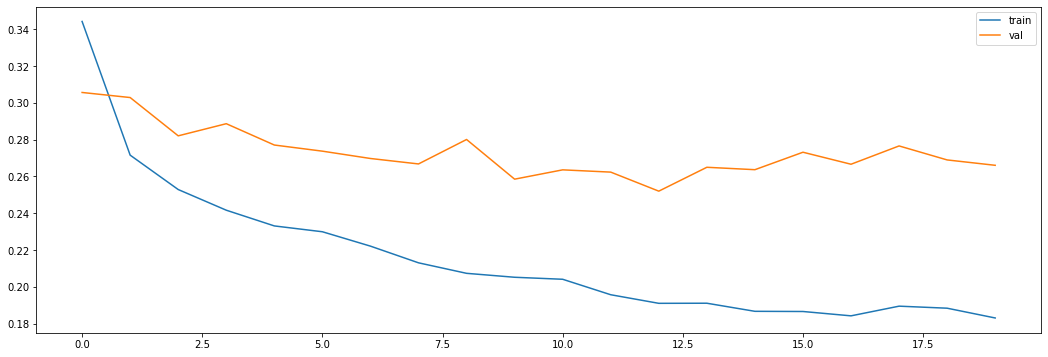

In [86]:
plt.plot(history, label="train")
plt.plot(val_history, label="val")
plt.legend()
plt.show()

In [116]:
score = evaluate(model, train, target_col=target_col)
print(score)

Loss 0.13293: 100%|██████████| 262/262 [00:26<00:00,  9.87it/s]

0.13292747195361715


torch.Size([12, 27, 13])
torch.Size([12, 70, 8])


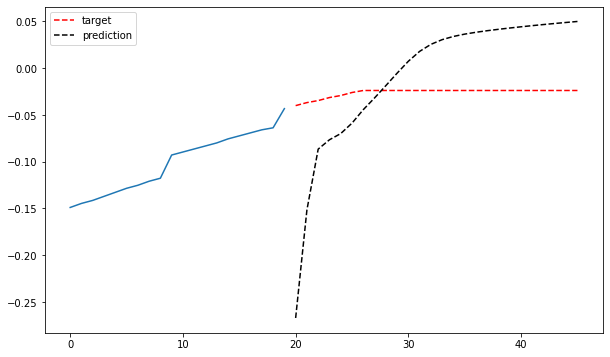

In [115]:
for (inputs, context), labels in train:
    outputs = model(inputs.float(), context.float())
    
    inputs, inputs_len = pad_packed_sequence(inputs, batch_first=True, padding_value=-999)
    labels, labels_len = pad_packed_sequence(labels, batch_first=True, padding_value=-999)
    outputs, outputs_len = pad_packed_sequence(outputs, batch_first=True, padding_value=-999)
    outputs = outputs.detach().numpy()
    
    print(inputs.shape) 
    print(labels.shape)
    
    plt.figure(figsize=(10, 6))
    plt.plot(
        np.arange(0, inputs_len[0]), 
        inputs[0, :inputs_len[0], target_col]
    )
    plt.plot(
        np.arange(inputs_len[0], labels_len[0]+inputs_len[0]), 
        labels[0, :labels_len[0], target_col], "r--", label="target"
    )
    plt.plot(
        np.arange(inputs_len[0], outputs_len[0]+inputs_len[0]), 
        outputs[0, :outputs_len[0], target_col], "k--", label="prediction"
    )    
    plt.legend()
    plt.show()
    break